<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Data_Analysis_Machine_Learning/blob/master/7.%20Sentiment%20Analysis/Restaurant%20Review%20Classification/Restaurant_Review_Classification_And_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Content:
1. [Preparing Project](#1)
    * 1.1 [Kaggle Connection](#1.1)
    * 1.2 [Downloading Dataset](#1.2)
    * 1.3 [Libraries](#1.3)
    * 1.4 [Import Dataset](#1.4)
2. [Data Exploration](#2)
    * 2.1 [Getting To Know The Variables](#2.1)
    * 2.2 [Missing Values](#2.2)
3. [EDA](#3)
    * 3.1 [Countplot](#3.1)
    * 3.2 [WordCloud](#3.2)
    * 3.3 [Length Of Reviews](#3.3)
4. [Preprocessing](#4)
    * 4.1 [Text Cleansing](#4.1)
    * 4.2 [Creating Bag Of Words](#4.2)
5. [Modelling](#5)
    * 5.1 [Spliting Train/Test Sets](#5.1)
    * 5.2 [Naive Bayes Model](#5.2)
        * 5.2.1 [Naive Bayes Model Accuracy](#5.2.1)
    * 5.3 [XGBoost Classifier](#5.3)
        * 5.3.1 [XGBoost Model Accuracy](#5.3.1)
6. [Predicting Single Review](#6)
    * 6.1 [Positive Review](#6.1)
    * 6.3 [Megative Review](#6.2)


# 1. Preparing Project <a id=1></a>

## 1.1 Kaggle Connection <a id=1.1></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_PASS"] = userdata.get('KAGGLE_PASS')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

## 1.2 Downloading Dataset <a id=1.2></a>

In [2]:
!kaggle datasets download -d akram24/restaurant-reviews

Dataset URL: https://www.kaggle.com/datasets/akram24/restaurant-reviews
License(s): CC0-1.0
  0% 0.00/24.1k [00:00<?, ?B/s]
100% 24.1k/24.1k [00:00<00:00, 25.9MB/s]


In [3]:
!unzip restaurant-reviews.zip

Archive:  restaurant-reviews.zip
  inflating: Restaurant_Reviews.tsv  


## 1.3 Libraries <a id=1.3></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1.4 Import Dataset <a id=1.4></a>

In [5]:
df = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t', quoting=3)

# quoting=3: we have many double quotes within the text, we have to ignore these double quotes
# it can lead to an execution error

# 2. Data Exploration <a id=2></a>

In [6]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [7]:
df.shape

(1000, 2)

In [8]:
df.dtypes

Review    object
Liked      int64
dtype: object

In [9]:
df.columns

Index(['Review', 'Liked'], dtype='object')

## 2.1 Getting To Know The Variables <a id=2.1></a>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


This DataFrame contains 1000 rows of data with 2 columns:
* "Review" (object dtype): Contains text data, likely customer reviews or comments. All 1000 entries are non-null.
* "Liked" (int64 dtype): Contains integer values, possibly representing a binary classification (e.g., 1 for liked, 0 for not liked) or a rating score. All 1000 entries are non-null.

## 2.2 Missing Values <a id=2.2></a>

In [11]:
df.isnull().values.any()

False

In [12]:
df.isnull().sum()

Review    0
Liked     0
dtype: int64

# 3. EDA <a id=3></a>

## 3.1 Countplot <a id=3.1></a>

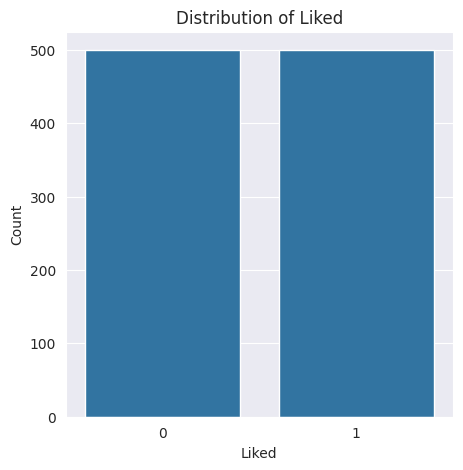

In [13]:
plt.figure(figsize=(5, 5))
sns.set_style('darkgrid')
sns.countplot(data=df, x='Liked')
plt.title('Distribution of Liked')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.show()

In [14]:
df['Liked'].value_counts()

Liked
1    500
0    500
Name: count, dtype: int64

## 3.2 WordCloud <a id=3.2></a>

In [15]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

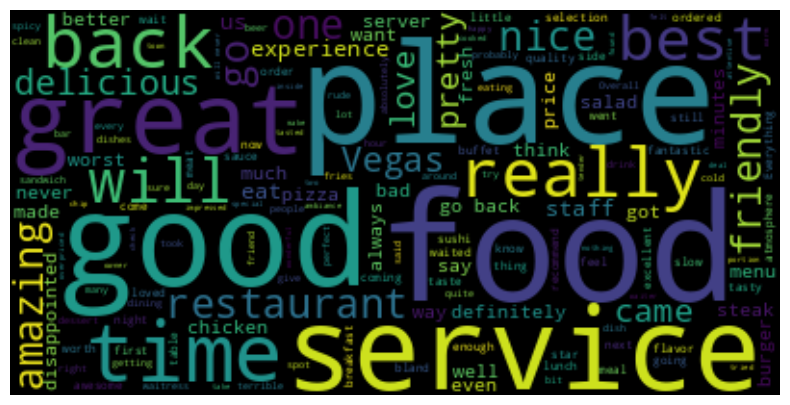

In [16]:
text = df['Review'].to_list()
text = ' '.join(text)
wordcloud = WordCloud(max_words=500).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3.3 Length Of Reviews <a id=3.3></a>

In [17]:
df['Length'] = df['Review'].apply(len)
df

,Review,Liked,Length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


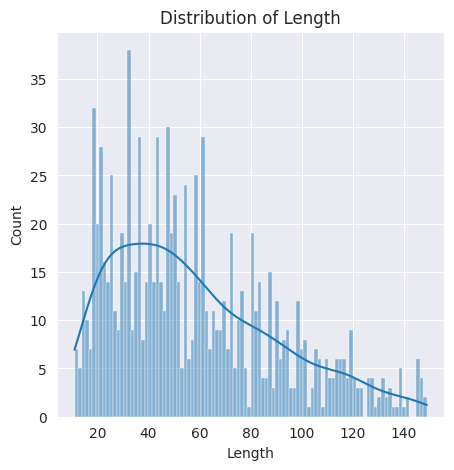

In [18]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='Length', bins=100, kde=True)
plt.title('Distribution of Length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# 4. Preprocessing <a id=4></a>

In [19]:
# Spliting Positive and Negative Reviews
positive = df[df['Liked'] == 1]
negative = df[df['Liked'] == 0]

In [20]:
positive

,Review,Liked,Length
0,Wow... Loved this place.,1,24
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
8,The fries were great too.,1,25
9,A great touch.,1,14
...,...,...,...
899,"Overall, a great experience.",1,28
901,Their regular toasted bread was equally satisf...,1,97
907,The chips and sals a here is amazing!!!!!!!!!!...,1,55
909,This is my new fav Vegas buffet spot.,1,37


In [21]:
negative

,Review,Liked,Length
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
5,Now I am getting angry and I want my damn pho.,0,46
6,Honeslty it didn't taste THAT fresh.),0,37
7,The potatoes were like rubber and you could te...,0,111
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


## 4.1 Text Cleansing <a id=4.1></a>

In [37]:
df = df.drop(columns='Length')

In [38]:
# Import the libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords            # Import the downloaded stopwords
from nltk.stem.porter import PorterStemmer   # We will use PorterStemmer class to apply the stemming on reviews

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
corpus = [] # this list will contain all the cleaned reviews from our dataset

"""
  sub function: it can replace anything with anything that we want
  we will keep only english letters, remaining all will be replaced by space (' ')
  ^ means not
  dataset['Review'][i]: selecting the column review from the dataset
"""

for i in range(0,1000):
  review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
  review = review.lower()
  review = review.split()

  ps = PorterStemmer()
  all_stopwards = stopwords.words('english')
  all_stopwards.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwards)] # stem the words which are not the stopwards
  review = ' '.join(review)
  corpus.append(review)

In [40]:
print(corpus)

['wow love place', 'crust not good', 'not tasti textur nasti', 'stop late may bank holiday rick steve recommend love', 'select menu great price', 'get angri want damn pho', 'honeslti tast fresh', 'potato like rubber could tell made ahead time kept warmer', 'fri great', 'great touch', 'servic prompt', 'would not go back', 'cashier care ever say still end wayyy overpr', 'tri cape cod ravoli chicken cranberri mmmm', 'disgust pretti sure human hair', 'shock sign indic cash', 'highli recommend', 'waitress littl slow servic', 'place not worth time let alon vega', 'not like', 'burritto blah', 'food amaz', 'servic also cute', 'could care less interior beauti', 'perform', 'right red velvet cake ohhh stuff good', 'never brought salad ask', 'hole wall great mexican street taco friendli staff', 'took hour get food tabl restaur food luke warm sever run around like total overwhelm', 'worst salmon sashimi', 'also combo like burger fri beer decent deal', 'like final blow', 'found place accid could not

In [41]:
len(corpus)

1000

## 4.2 Creating Bag Of Words <a id=4.2></a>

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, -1].values

In [44]:
print("X: ", X.shape)
print("y:", y.shape)

X:  (1000, 1500)
y: (1000,)


# 5. Modelling <a id=5></a>

## 5.1 Splitting Train/Test Sets <a id=5.1></a>

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [46]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 5.2 Naive Bayes Model <a id=5.2></a>

In [47]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

GaussianNB()

In [48]:
y_pred = classifier_nb.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 1]

### 5.2.1 Naive Bayes Model Accuracy <a id=5.2.1></a>

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

nb_res = pd.DataFrame([['Naive Bayes', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [55]:
nb_res

,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.725,0.725,0.725,0.725


## 5.3 XGBoost Classifier <a id=5.3></a>

In [50]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier(random_state=0)
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

### 5.3.1 XGBoost Model Accuracy <a id=5.3.1></a>

In [58]:
y_pred = classifier_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

xgb_res = pd.DataFrame([['XGBoost', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [59]:
result = []
result = pd.concat([xgb_res, nb_res], ignore_index = True)
result

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.725,0.792683,0.631068,0.702703
1,Naive Bayes,0.725,0.725000,0.725000,0.725000


# 6. Predicting Single Review <a id=6></a>

## 6.1 Positive Review <a id=6.1></a>

In [60]:
new_review = 'I love this restaurant so much'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_x_test = cv.transform(new_corpus).toarray()
new_y_pred = classifier_nb.predict(new_x_test)
print(new_y_pred)

[1]


## 6.2 Negative Review <a id=6.2></a>

In [61]:
new_review = 'I hate this restaurant so much'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_x_test = cv.transform(new_corpus).toarray()
new_y_pred = classifier_nb.predict(new_x_test)
print(new_y_pred)

[0]
